In [1]:
#pip install -q -U keras-tuner

In [1]:
# Libraries

import pandas as pd
import time
import numpy as np
import random
import os
from tqdm import tqdm
import itertools
import PIL

# Data Analysis
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img
import keras_tuner as kt
from tensorflow import keras

# Sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Classes Tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

%matplotlib inline

## Preprocessing

In [2]:
# Emplacement
path = 'D:/documents/GitHub/Radios_COVID19/COVID-19_Radiography_Dataset'

dirs = ["Normal/images/","COVID/images/","Lung_Opacity/images/","Viral Pneumonia/images/"]
dirsm = ["Normal/masks/","COVID/masks/","Lung_Opacity/masks/","Viral Pneumonia/masks/"]

id_dir = 5

# Classes de 0 à 3 dans la suite
classes = ("Normal","COVID ","Lung_Opacity","Viral Pneumonia") 
nbClasses = len(classes)

In [3]:
# Création des 4 listes de noms d'images

normal_imgs = [fn for fn in os.listdir(f'{path}/Normal/masked_images') if fn.endswith('.png')]
covid_imgs = [fn for fn in os.listdir(f'{path}/COVID/masked_images') if fn.endswith('.png')]
pneumonia_imgs = [fn for fn in os.listdir(f'{path}/Viral Pneumonia/masked_images') if fn.endswith('.png')]
lung_opacity_imgs = [fn for fn in os.listdir(f'{path}/Lung_Opacity/masked_images') if fn.endswith('.png')]

In [4]:
# Concaténation des emplacements de toutes les images dans une liste unique
liste_paths = []

for fn in normal_imgs :
    liste_paths.append(f'{path}/Normal/masked_images/' + fn)
for fn in covid_imgs :
    liste_paths.append(f'{path}/COVID/masked_images/' + fn)
for fn in pneumonia_imgs :
    liste_paths.append(f'{path}/Viral Pneumonia/masked_images/' + fn)
for fn in lung_opacity_imgs :
    liste_paths.append(f'{path}/Lung_Opacity/masked_images/' + fn)

# Découpage des noms de chaque emplacement et récupération de la classe (liste de listes)
liste_paths_classes = list(map(lambda x : [x, x.split('/')[id_dir]], liste_paths)) 

In [5]:
# Création Dataframe des emplacements et classes images BRUTES
df = pd.DataFrame(liste_paths_classes, columns = ['filepath', 'nameLabel'])

# Remplacement des classes sous forme littérale par index
df['label'] = df['nameLabel'].replace(df.nameLabel.unique(), [*range(len(df.nameLabel.unique()))])
df['label'] = df['label'].astype(str)

# Mélange du dataframe
df = df.sample(frac = 1, random_state = 42)
df = df.reset_index(drop=True)

# Nettoyage variables inutiles
del liste_paths

ech_size = 2000

df = df[0:ech_size]
df.head()

,filepath,nameLabel,label
0,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Lung_Opacity,3
1,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Normal,0
2,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Viral Pneumonia,2
3,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,COVID,1
4,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Viral Pneumonia,2


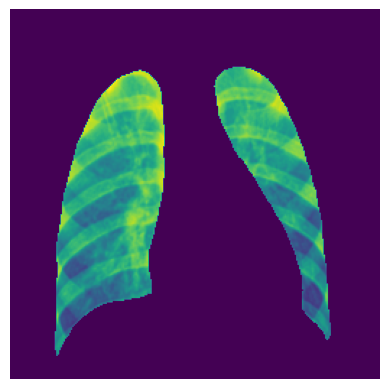

In [6]:
#Charger Exemple Image
filepath = df.filepath[9]

im = tf.io.read_file(filepath)
im = tf.image.decode_jpeg(im, channels = 1)
plt.imshow(im)
plt.axis('off');

In [7]:
size = (256, 256)
ratio_val = 0.2 
batch_generator = 32

# Séparation dataframe en ensemble entraiement et validation
train_total, test = train_test_split(df, test_size = ratio_val, shuffle = False)
train, valid = train_test_split(train_total, test_size = 0.1)

# Création des itérateurs qui chargeront des lots d'images
datagen = ImageDataGenerator( )
test_datagen = ImageDataGenerator( )

print(f"Number of rows in TRAIN total set: {len(train_total)}")
print(f" - Number of rows in train_set: {len(train)}")
print(f" - Number of rows in valid_set: {len(valid)}")

train_generator = datagen.flow_from_dataframe(dataframe = train,
                                              x_col="filepath",
                                              y_col="label",
                                              class_mode = "sparse",
                                              target_size = size,
                                              batch_size = batch_generator,
                                              color_mode = "grayscale")

valid_generator = datagen.flow_from_dataframe(dataframe = valid,
                                              x_col="filepath",
                                              y_col="label",
                                              class_mode = "sparse",
                                              target_size = size,
                                              batch_size = batch_generator,
                                              color_mode = "grayscale")

Number of rows in TRAIN total set: 1600
 - Number of rows in train_set: 1440
 - Number of rows in valid_set: 160
Found 1440 validated image filenames belonging to 4 classes.
Found 160 validated image filenames belonging to 4 classes.


In [8]:
print(f"Number of rows in TEST set: {len(test)}")

test_generator = test_datagen.flow_from_dataframe(dataframe = test,
                                                x_col="filepath",
                                                y_col="label",
                                                class_mode = "sparse",
                                                target_size = size,
                                                batch_size = batch_generator,
                                                color_mode = "grayscale",
                                                shuffle = False) 

X_test = []

for filepath in tqdm(test['filepath']) :
    im = tf.io.read_file(filepath)
    im = tf.image.decode_jpeg(im, channels = 1)
    im = tf.image.resize (im, size)
    X_test.append([im])
    
X_test = tf.concat(X_test, axis = 0)

Number of rows in TEST set: 400
Found 400 validated image filenames belonging to 4 classes.


100%|██████████| 400/400 [00:00<00:00, 614.10it/s]


## LeNet Model

In [9]:
hp = kt.HyperParameters()

In [13]:
def model_builder(hp) :
    model = Sequential()
 
    model.add(Conv2D(filters = 30 , kernel_size = (5,5), input_shape =[256,256,1], activation = "relu"))
    model.add(MaxPooling2D(pool_size = (2,2)))

    model.add(Conv2D(filters = 16, kernel_size = (3,3), activation = "relu"))
    model.add(MaxPooling2D(pool_size = (2,2)))

    model.add(Flatten())
    model.add(Dropout(rate = 0.2))

    model.add(Dense(units = 128, activation = "relu"))
    model.add(Dense(units = 4, activation = "softmax"))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Float('lrate_adam', min_value=1e-4, max_value=1e-2, sampling='LOG')
        
    model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate), 
                  metrics = ["accuracy"])
    
    return model

In [14]:
model_builder(kt.HyperParameters()).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 30)      780       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 30)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 16)      4336      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 61504)             0         
                                                                 
 dropout (Dropout)           (None, 61504)             0

## Entrainement Modèle

In [15]:
tuner = kt.RandomSearch(hypermodel = model_builder, objective = "val_accuracy", max_trials = 3, executions_per_trial = 2,
                        overwrite = True, directory = "kt", project_name = "radio",)

stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

train_size = train_generator.samples
valid_size = valid_generator.samples

batch_turner = 32
epochs_turner = 10

tuner.search(train_generator,
                 epochs = epochs_turner,
                 steps_per_epoch = train_size // batch_turner,
                 validation_data = valid_generator,
                 validation_steps = valid_size // batch_turner,
                 callbacks = [stop_early])

Trial 3 Complete [00h 05m 20s]
val_accuracy: 0.4781250059604645

Best val_accuracy So Far: 0.6624999940395355
Total elapsed time: 00h 17m 45s
INFO:tensorflow:Oracle triggered exit


In [16]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(best_hps.get('lrate_adam'))

0.0034070984533815926


In [17]:
# Build the model with the optimal hyperparameters and train it on the data for 20 epochs
model = tuner.hypermodel.build(best_hps)

batch_model = 32
epochs = 10

history = model.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = train_size // batch_model,
                    validation_data = valid_generator,
                    validation_steps = valid_size // batch_model)

Epoch 1/10
45/45 [==============================] - 24s 512ms/step - loss: 56.8713 - accuracy: 0.4007 - val_loss: 1.0539 - val_accuracy: 0.5500
Epoch 2/10
45/45 [==============================] - 23s 505ms/step - loss: 0.7869 - accuracy: 0.6694 - val_loss: 0.9629 - val_accuracy: 0.5875
Epoch 3/10
45/45 [==============================] - 23s 502ms/step - loss: 0.3064 - accuracy: 0.9069 - val_loss: 1.2097 - val_accuracy: 0.5875
Epoch 4/10
45/45 [==============================] - 22s 483ms/step - loss: 0.1265 - accuracy: 0.9618 - val_loss: 1.6307 - val_accuracy: 0.6000
Epoch 5/10
45/45 [==============================] - 23s 501ms/step - loss: 0.0597 - accuracy: 0.9771 - val_loss: 2.0373 - val_accuracy: 0.5875
Epoch 6/10
45/45 [==============================] - 22s 487ms/step - loss: 0.0531 - accuracy: 0.9792 - val_loss: 1.9916 - val_accuracy: 0.5813
Epoch 7/10
45/45 [==============================] - 22s 485ms/step - loss: 0.0392 - accuracy: 0.9868 - val_loss: 2.3073 - val_accuracy: 0.600

In [18]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

print('Best epoch: %d' % (best_epoch,))

Best epoch: 8


In [20]:
#Réinstanciez l'hypermodèle et entraînez-le avec le nombre optimal d'époques d'en haut.

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_generator, epochs = best_epoch, 
               steps_per_epoch = train_size // batch_model,
               validation_data = valid_generator,
               validation_steps = valid_size // batch_model)

Epoch 1/8
45/45 [==============================] - 23s 491ms/step - loss: 27.7854 - accuracy: 0.2958 - val_loss: 1.3824 - val_accuracy: 0.3187
Epoch 2/8
45/45 [==============================] - 23s 512ms/step - loss: 1.2097 - accuracy: 0.4521 - val_loss: 1.1731 - val_accuracy: 0.4875
Epoch 3/8
45/45 [==============================] - 23s 513ms/step - loss: 0.7811 - accuracy: 0.6736 - val_loss: 1.1354 - val_accuracy: 0.5437
Epoch 4/8
45/45 [==============================] - 23s 505ms/step - loss: 0.4527 - accuracy: 0.8208 - val_loss: 1.3447 - val_accuracy: 0.5500
Epoch 5/8
45/45 [==============================] - 23s 510ms/step - loss: 0.2484 - accuracy: 0.9007 - val_loss: 1.7158 - val_accuracy: 0.5688
Epoch 6/8
45/45 [==============================] - 22s 492ms/step - loss: 0.1780 - accuracy: 0.9479 - val_loss: 1.9755 - val_accuracy: 0.5312
Epoch 7/8
45/45 [==============================] - 23s 504ms/step - loss: 0.1496 - accuracy: 0.9569 - val_loss: 1.9991 - val_accuracy: 0.5688
Epoch

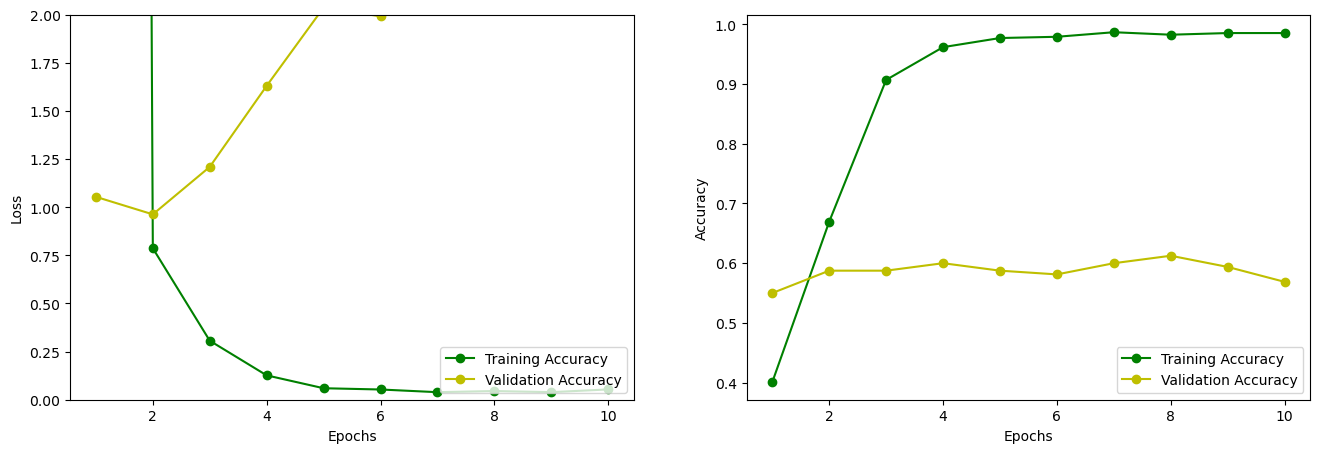

In [22]:
# Courbes de perte et d'accuracy
plt.figure(figsize = (16,5))

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.subplot(121)
plt.plot(epochs, train_loss, 'g-o', label = 'Training Accuracy')
plt.plot(epochs, val_loss, 'y-o',  label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,2)

plt.subplot(122)
plt.plot(epochs, train_acc, 'g-o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'y-o',  label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show();

## Model Performance 

In [23]:
print('TRAIN accuracy & loss:', hypermodel.evaluate(train_generator))
print('\n')
print('TEST accuracy & loss:', hypermodel.evaluate(test_generator))

45/45 [==============================] - 7s 154ms/step - loss: 0.0401 - accuracy: 0.9910
TRAIN accuracy & loss: [0.040106840431690216, 0.9909722208976746]


13/13 [==============================] - 2s 155ms/step - loss: 2.1522 - accuracy: 0.5300
TEST accuracy & loss: [2.152198553085327, 0.5299999713897705]


#### Predictions

In [24]:
y_test = test_generator.classes
y_test = pd.DataFrame(y_test).astype(int)

y_pred = np.argmax(hypermodel.predict(test_generator), axis = 1)

13/13 [==============================] - 2s 129ms/step


#### Confusion Matrix

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

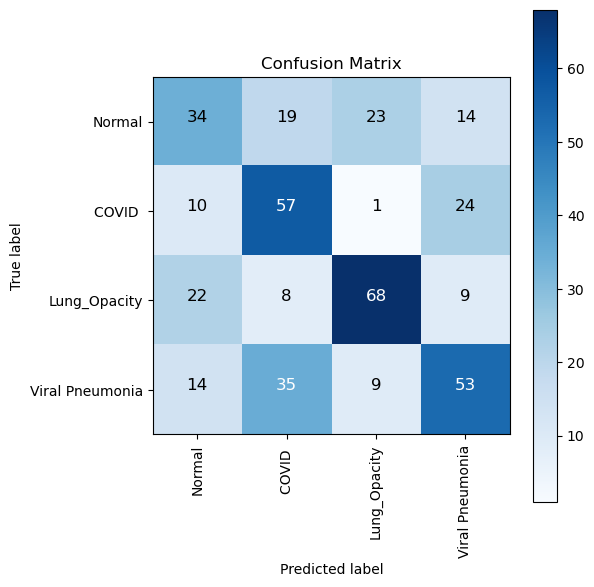

[[34 19 23 14]
 [10 57  1 24]
 [22  8 68  9]
 [14 35  9 53]]


In [26]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, classes, normalize = False)
print(cm)

#### Classification Report

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.38      0.40        90
           1       0.48      0.62      0.54        92
           2       0.67      0.64      0.65       107
           3       0.53      0.48      0.50       111

    accuracy                           0.53       400
   macro avg       0.53      0.53      0.52       400
weighted avg       0.53      0.53      0.53       400



## Predictions on Test Images 

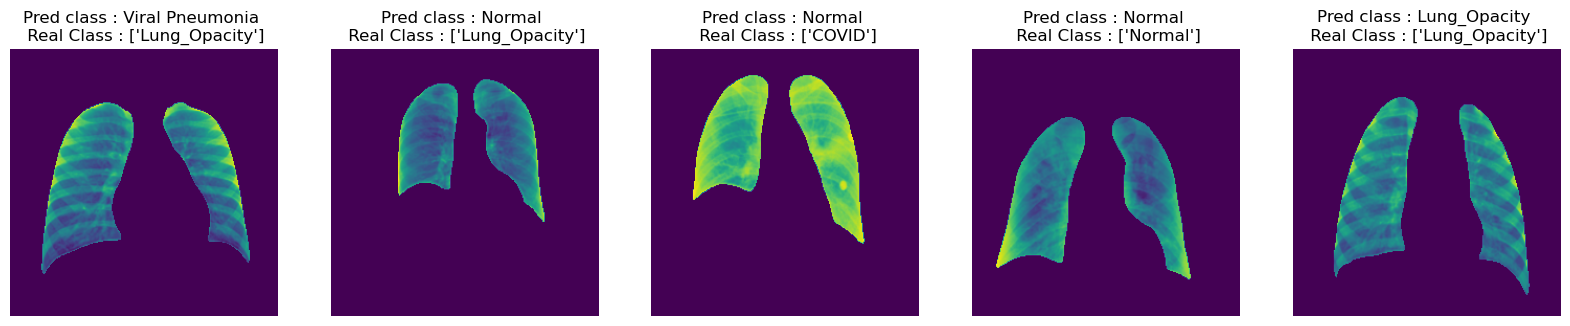

In [28]:
#Prédiction du modèle

indices_random = tf.random.uniform([5], 0, len(test['filepath']), dtype = tf.int32)

plt.figure(figsize = (20,7))

for i, idx in enumerate(indices_random) :
    plt.subplot(1,5,i+1)
    plt.imshow(tf.cast(X_test[idx], tf.int32))
    plt.axis('off')
    plt.title('Pred class : {} \n Real Class : {}'.format(df.nameLabel.unique()[y_pred[idx]], df.nameLabel.unique()[y_test.values[idx]]))

In [ ]:
model.save_weights("model_lenet_kerastuner_2000mkd.h5")

In [ ]:
model.load_weights("C:/Users/utilisateur/COVID19 - Projet/model_lenet_kerastuner_2000mkd.h5")